In [3]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import keras

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
from tensorflow.keras.metrics import MeanIoU

In [6]:
from PIL import Image
from PIL import ImageEnhance

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [8]:
from patchify import patchify

In [9]:
import os

root_directory = os.path.join(os.getcwd(), "dataset")  # Get the full path
print("Dataset path:", root_directory)

if os.path.exists(root_directory):
    print("Dataset directory found!")
else:
    print("Dataset directory NOT found!")

Dataset path: /Users/srinivasadesikan/SURYA_AD4/dataset
Dataset directory found!


In [10]:
patch_size = 512 # Or any other size you need

In [11]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images_IR':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):   #Only read png images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner

                img_enhancer = ImageEnhance.Brightness(image)
                factor = 1.5
                enhanced_output = img_enhancer.enhance(factor)
                image = enhanced_output

                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name, len(image_dataset))
                if image.shape[0] < patch_size or image.shape[1] < patch_size:
                    print(f"Skipping {image_name}: Image too small for patch size {patch_size}")
                    continue

                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/0.png 0
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/1.png 6
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/10.png 21
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/100.png 24
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/101.png 36
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/102.png 51
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/103.png 66
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/104.png 81
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/105.png 96
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/106.png 111
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dataset/images_IR/11.png 126
Now patchifying image: /Users/srinivasadesikan/SURYA_AD4/dat

In [13]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name, len(mask_dataset))
                if mask.shape[0] < patch_size or mask.shape[1] < patch_size:
                    print(f"Skipping {mask_name}: Mask too small for patch size {patch_size}")
                    continue

                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/38.png 0
Skipping 38.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/54.png 0
Skipping 54.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/57.png 0
Skipping 57.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/60.png 0
Skipping 60.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/62.png 0
Skipping 62.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/67.png 0
Skipping 67.png: Mask too small for patch size 512
Now patchifying mask: /Users/srinivasadesikan/SURYA_AD4/dataset/discards/masks/69.png 0
Skipping 69.png: Mask too small for patch size 512
Now patchifying mask: /User

In [11]:
scaler = MinMaxScaler()
image_dataset = []
mask_dataset = []

# Define directories
image_dir = "/Users/srinivasadesikan/SURYA_AD4/dataset/images_IR"
mask_dir = "/Users/srinivasadesikan/SURYA_AD4/dataset/masks"

# List and sort files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, img_file)

    if not os.path.exists(mask_path):
        print(f"Skipping {img_file}: No corresponding mask")
        continue

    # Read and crop image and mask
    image = cv2.imread(img_path, 1)  # Read as BGR
    mask = cv2.imread(mask_path, 1)  # Read as BGR (can also be grayscale)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert for color masks

    h, w = image.shape[:2]
    new_h = (h // patch_size) * patch_size
    new_w = (w // patch_size) * patch_size

    if new_h < patch_size or new_w < patch_size:
        print(f"Skipping {img_file}: Too small for patch size {patch_size}")
        continue

    # Crop from top-left
    image = Image.fromarray(image).crop((0, 0, new_w, new_h))
    mask = Image.fromarray(mask).crop((0, 0, new_w, new_h))

    # Optional brightness enhancement
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.5)

    image = np.array(image)
    mask = np.array(mask)

    # Patchify
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            img_patch = patches_img[i, j, 0]
            mask_patch = patches_mask[i, j, 0]

            # Normalize image patch
            img_patch = scaler.fit_transform(img_patch.reshape(-1, 3)).reshape(img_patch.shape)

            image_dataset.append(img_patch)
            mask_dataset.append(mask_patch)

# Convert to numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

print(f"Total image patches: {len(image_dataset)}")
print(f"Total mask patches: {len(mask_dataset)}")

Total image patches: 433
Total mask patches: 433


In [12]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

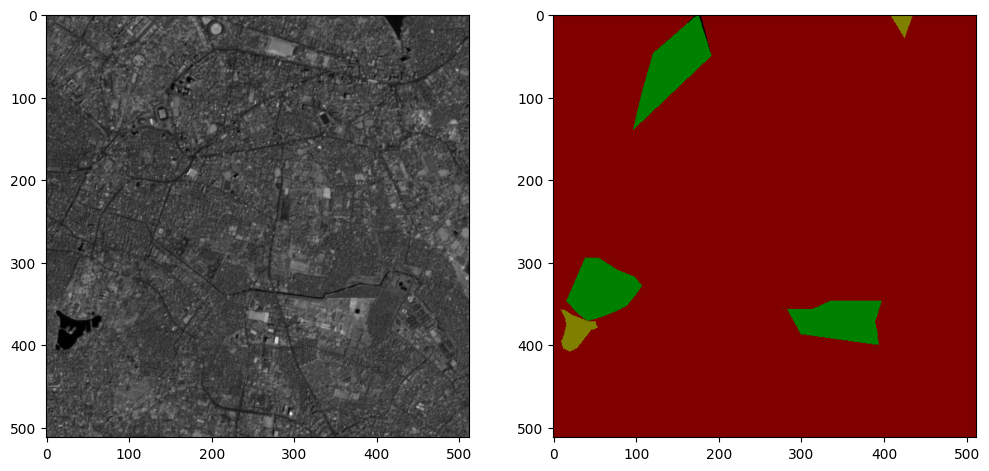

353


In [41]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()
print(image_number)



In [128]:
Builtup = '#800000'.lstrip('#')
Builtup = np.array(tuple(int(Builtup[i:i+2], 16) for i in (0, 2, 4))) # 128,0,0

Vegetation = '#008000'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #0,128,0

Water = '808000'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #128,128,0

Unlabeled = '#000000'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [129]:
label = mask_patch

In [130]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values.
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Builtup,axis=-1)] = 0
    label_seg [np.all(label==Vegetation,axis=-1)] = 1
    label_seg [np.all(label==Water,axis=-1)] = 2
    label_seg[np.all(label == Unlabeled, axis=-1)] = 3
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [131]:
def set_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_2D_label(mask_dataset[i])
        labels.append(label)

    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)

    print("Unique labels in label dataset are: ", np.unique(labels))
    n_classes = len(np.unique(labels))
    from tensorflow.keras.utils import to_categorical
    labels_cat = to_categorical(labels, num_classes=n_classes)


    return labels_cat

In [132]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [133]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3]


In [2]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()
print(image_number)

NameError: name 'image_dataset' is not defined